# Text Classification

In [27]:
from datasets import list_datasets, load_dataset
import pandas as pd
import matplotlib.pyplot as plt

## The Dataset

In [6]:
[x for x in list_datasets() if x.startswith('emo')]

['emo', 'emotion', 'emotone_ar']

In [8]:
emotions = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<hr>

In [9]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [11]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
emotions["train"][0:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

### Set Dataset Format

Set format to `pandas` to work with DataFrame object.

In [15]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [18]:
emotions['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [20]:
labels = emotions['train'].features['label']

In [26]:
df['label_name'] = df['label'].apply(labels.int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


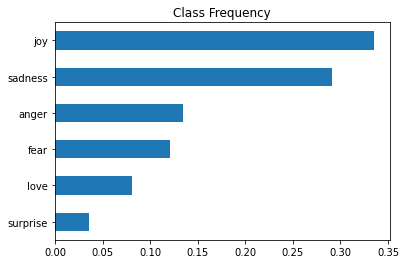

In [30]:
df['label_name'].value_counts(normalize=True, ascending=True).plot.barh()
plt.title('Class Frequency')
plt.show()

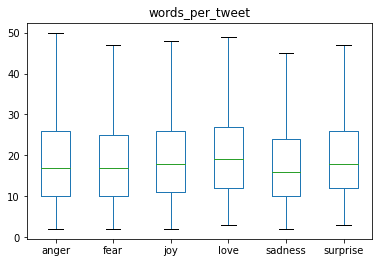

In [36]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot(
    'words_per_tweet',
    by='label_name',
    showfliers=False,
    grid=False
)
plt.suptitle('')
plt.xlabel('')
plt.show()

### Reset Dataset Format

Reset format for further work.

In [37]:
emotions.reset_format()

## Tokenization